In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


sierraleone= pd.read_csv(r"data\sierraleone-bumbuna.csv", parse_dates=["Timestamp"])

print(sierraleone.head(7))

print(sierraleone.dtypes)

print(sierraleone.info())

print(sierraleone.describe())  

print(sierraleone.isna().sum())



In [ ]:
num_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "Tamb", "RH", "WS", "WSgust", "WSstdev", "WD", "WDstdev", "BP", "Cleaning", "Precipitation", "TModA", "TModB"]

def count_outliers_iqr(df, columns):
    """
    Counts outliers in specified columns using the IQR method.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list): List of column names to check

    Returns:
        dict: Dictionary with column names as keys and outlier counts as values
    """
    outlier_counts = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        count = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_counts[col] = count
        print(round((count/len(df[col])) * 100, 2))

    print("\nOutlier Counts (IQR method):")
    for col, count in outlier_counts.items():
        print(f" - {col}: {count} outliers")


count_outliers_iqr(sierraleone, num_cols)

In [ ]:
from scipy.stats import zscore

def count_outliers_zscore(df, columns):
    """
    Counts outliers in specified columns using the Z-score method.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list): List of column names to check

    Returns:
        dict: Dictionary with column names as keys and outlier counts as values
    """
    outlier_counts = {}

    for col in columns:
        z_scores = zscore(df[col].dropna())
        outliers = np.abs(z_scores) > 3
        count = outliers.sum()
        outlier_counts[col] = count
        print(round((count/len(df[col])) * 100, 2))
        
    print(f"\nOutlier Counts (Z-score method, threshold = 3):")
    for col, count in outlier_counts.items():
        print(f" - {col}: {count} outliers")


count_outliers_zscore(sierraleone, num_cols)


#Plotting the outliers for a better view
for col in num_cols:
    z_scores = zscore(sierraleone[col].dropna())
    outlier_mask = abs(z_scores) > 3

    # Get actual outlier values with their timestamps
    outliers = sierraleone.loc[sierraleone[col].dropna().index[outlier_mask], ['Timestamp', col]]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.scatter(outliers['Timestamp'], outliers[col], color='red', label='Outliers')
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.title(f'Outliers in {col} (Z-score > 3)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [2]:
# Sort by column: 'Timestamp' (ascending)
sierraleone = sierraleone.sort_values(['Timestamp'])

# Drop column: 'Comments'
sierraleone_clean = sierraleone.drop(columns=['Comments'])

sierraleone_clean.to_csv("data/sierra_leone_clean.csv", index=False)

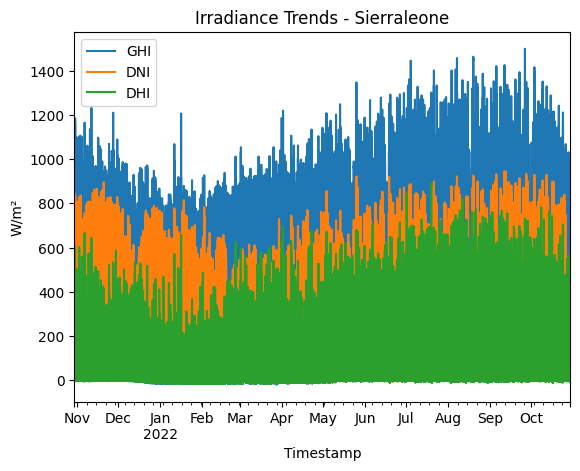

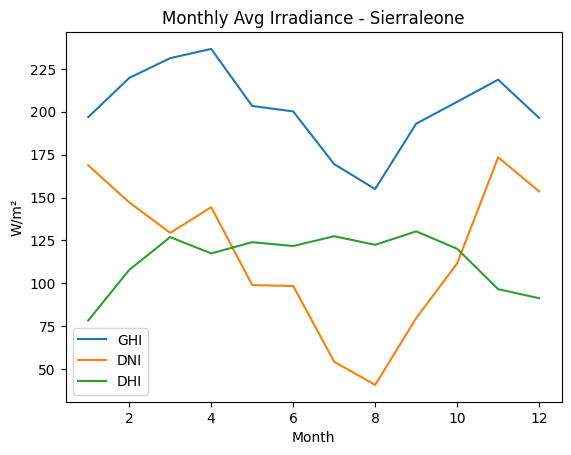

In [7]:
irradiance_cols = ['GHI', 'DNI', 'DHI']
sierraleone_clean.set_index('Timestamp')[irradiance_cols].plot(title="Irradiance Trends - Sierraleone")
plt.ylabel("W/m²")
plt.show()


sierraleone_clean['Month'] = sierraleone_clean['Timestamp'].dt.month

monthly_avg_SI = sierraleone_clean.groupby('Month')[irradiance_cols].mean()
monthly_avg_SI.plot(title="Monthly Avg Irradiance - Sierraleone")
plt.ylabel("W/m²")
plt.show()

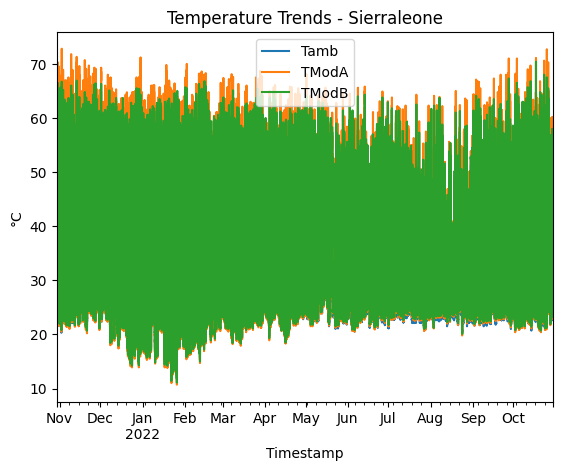

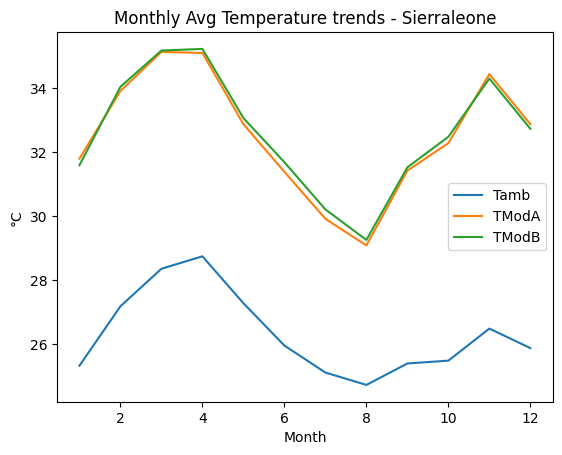

In [8]:
temp_cols = ['Tamb', 'TModA', 'TModB']
sierraleone_clean.set_index('Timestamp')[temp_cols].plot(title="Temperature Trends - Sierraleone")
plt.ylabel("°C")
plt.show()


monthly_avg_ST = sierraleone_clean.groupby('Month')[temp_cols].mean()
monthly_avg_ST.plot(title="Monthly Avg Temperature trends - Sierraleone")
plt.ylabel("°C")
plt.show()

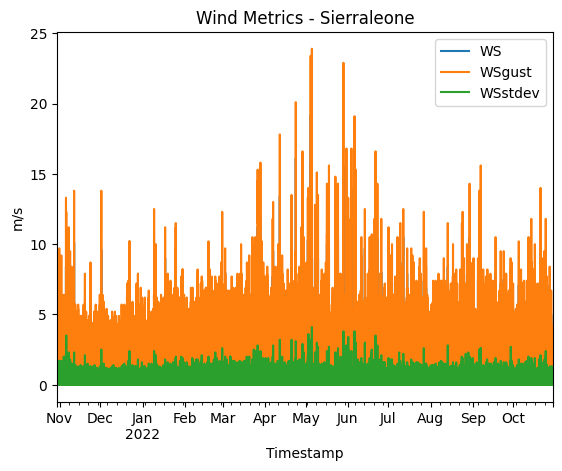

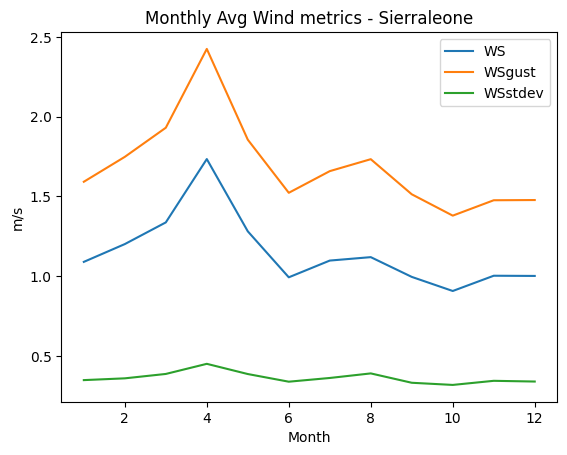

In [9]:
wind_cols = ['WS', 'WSgust', 'WSstdev']
sierraleone_clean.set_index('Timestamp')[wind_cols].plot(title="Wind Metrics - Sierraleone")
plt.ylabel("m/s")
plt.show()


monthly_avg_SW = sierraleone_clean.groupby('Month')[wind_cols].mean()
monthly_avg_SW.plot(title="Monthly Avg Wind metrics - Sierraleone")
plt.ylabel("m/s")
plt.show()


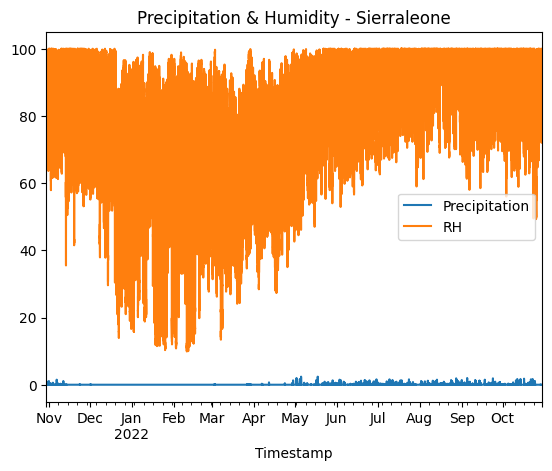

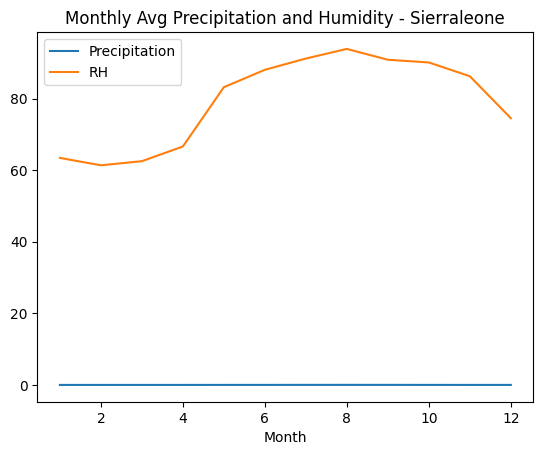

In [10]:
precip_cols = ['Precipitation', 'RH']
sierraleone_clean.set_index('Timestamp')[precip_cols].plot(title="Precipitation & Humidity - Sierraleone")
plt.show()


monthly_avg_SP = sierraleone_clean.groupby('Month')[precip_cols].mean()
monthly_avg_SP.plot(title="Monthly Avg Precipitation and Humidity - Sierraleone")
plt.show()

In [ ]:
# Group by Cleaning flag and plot average ModA & ModB

# Group and calculate mean
cleaning_impact = sierraleone_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()

# Plot
cleaning_impact_melted = cleaning_impact.melt(id_vars='Cleaning', var_name='Module', value_name='Average Power')
sns.barplot(data=cleaning_impact_melted, x='Cleaning', y='Average Power', hue='Module')
plt.title("Average ModA & ModB Output Pre/Post Cleaning")
plt.xticks([0, 1], ['Before Cleaning', 'After Cleaning'])
plt.tight_layout()
plt.show()

In [ ]:
# Heatmap of Correlation Matrix

corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
sns.heatmap(sierraleone_clean[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()



In [ ]:
# Wind Speed vs. GHI
sns.scatterplot(data=sierraleone_clean, x='WS', y='GHI')
plt.title('Wind Speed vs. GHI')
plt.show()

# Wind Gust vs. GHI
sns.scatterplot(data=sierraleone_clean, x='WSgust', y='GHI')
plt.title('Wind Gust vs. GHI')
plt.show()

# Wind Direction vs. GHI
sns.scatterplot(data=sierraleone_clean, x='WD', y='GHI')
plt.title('Wind Direction vs. GHI')
plt.show()

# RH vs Tamb
sns.scatterplot(data=sierraleone_clean, x='RH', y='Tamb')
plt.title('RH vs. Ambient Temperature')
plt.show()

# RH vs GHI
sns.scatterplot(data=sierraleone_clean, x='RH', y='GHI')
plt.title('RH vs. GHI')
plt.show()

In [ ]:
# Relationship: RH vs Tamb & RH vs GHI
sns.lmplot(data=sierraleone_clean, x='RH', y='Tamb')
plt.title('RH vs. Temperature')
plt.show()

sns.lmplot(data=sierraleone_clean, x='RH', y='GHI')
plt.title('RH vs. GHI')
plt.show()

In [ ]:
# Bubble Chart of GHI vs. Tamb with bubble size = RH

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sierraleone_clean, x='Tamb', y='GHI', size='RH', sizes=(10, 300), alpha=0.5)
plt.title('GHI vs Tamb (Bubble size = RH)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()


# Bubble Chart of GHI vs. Tamb with bubble size = BP

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sierraleone_clean, x='Tamb', y='GHI', size='BP', sizes=(10, 300), alpha=0.5)
plt.title('GHI vs Tamb (Bubble size = BP)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()
